# **Control de Velocidad de Motor DC**

**Autores:**

    - Miguel Angel Alvarez Guzman
    - Andres David Guerrero Rivera
    - Jose Vicente Zabaleta Montiel
    

## 1. Introducción

- **Objetivo del proyecto:**

  Diseñar e implementar un sistema de control para regular la velocidad de un motor DC utilizando un controlador por espacio de estados, implementado en hardware con Arduino y MicroPython. El sistema debe cumplir con especificaciones de desempeño: tiempo de establecimiento $t_s$ menor a 0.4 segundos y sobreimpulso $M_p$ inferior al 10%.

- **Resultados esperados:**

  Lograr un control robusto y preciso de la velocidad (RPM), validado mediante simulaciones en Python y pruebas experimentales en hardware, con seguimiento de referencias y tolerancia a perturbaciones.



---

## 2. Modelado del Motor DC

- **Modelo electromecánico:**  
  El motor DC se modela mediante ecuaciones eléctricas y mecánicas. La ecuación eléctrica se basa en la ley de Kirchhoff:  
  $$
  V(t) = R \cdot I(t) + L \cdot \frac{dI(t)}{dt} + K_e \cdot \omega(t)
  $$
  Mientras que la ecuación mecánica se deriva de la segunda ley de Newton:  
  $$
  J \cdot \frac{d\omega(t)}{dt} = K_t \cdot I(t) - B \cdot \omega(t) - T_L
  $$
 Donde:

  $R$: Resistencia de armadura

  $L$: Inductancia

  $K_e$: Constante de fuerza electromotriz

  $J$: Inercia

  $K_t$: Constante de torque

  $B$: Fricción viscosa

  $T_L$: Carga externa


  Parámetros del modelo:

  Los parámetros identificados experimentalmente son:

  $K = 2084.9898$ (ganancia estática)

  $\omega_n = 35.3737 \, \text{rad/s}$ (frecuencia natural)

  $\zeta = 0.7204$ (coeficiente de amortiguamiento)


  Función de transferencia:

  La función de transferencia en lazo abierto para velocidad es:

  $$G(s) = \frac{K \omega_n^2}{s^2 + 2 \zeta \omega_n s + \omega_n^2} = \frac{2.671 \times 10^5}{s^2 + 50.96s + 1251.3}$$

---

## 3. Identificación de Parámetros

**Método:**

Se aplicó una señal PWM al motor vía Arduino, midiendo la velocidad (RPM) con un sensor AS5600 a 100 Hz $T_s = 0.01 , \text{s}$. 

Los parámetros $K$, $\omega_n$, y $\zeta$ se estimaron mediante ajuste por mínimos cuadrados en Python **(scipy.curve_fit)**.

**Resultados:**

$ K = 2084.9898 $

$ \omega_n = 35.3737 , \text{rad/s}$

$ \zeta = 0.7204 $
Coeficiente de determinación: ( R^2 = 0.7606 )


---

## 4. Diseño de Controladores

**4.1. Compensador Adelanto-Atraso**

**Diseño:**
Se diseñó un compensador para mejorar la estabilidad (margen de fase) y reducir el error en estado estacionario. Los objetivos son:

Margen de fase: 50°
Factor de mejora del error: 10
La función de transferencia del compensador continuo es:

$$C(s) = K_c \cdot \frac{s + z_c}{s + p_c} \cdot \frac{s + z_a}{s + p_a}$$
Donde:

$K_c = 9.1946$
$z_c = 296.8202$ (cero de adelanto)
$p_c = 2737.8931$ (polo de adelanto)
$z_a = 90.1478$ (cero de atraso)
$p_a = 9.0148$ (polo de atraso)
Resultado final:

$$C(s) = \frac{9.195 s^2 + 3558 s + 2.46 \times 10^5}{s^2 + 2747 s + 2.468 \times 10^4}$$

Discretización:
Para implementación en Arduino, se discretizó usando el método de Tustin con $T_s = 0.01 \, \text{s}$:
$$C(z) = \frac{b_0 + b_1 z^{-1}}{1 + a_1 z^{-1}}$$
Coeficientes:

$b_0 = 5.64236527$, $b_1 = -5.64180107$
$a_0 = 1.0$, $a_1 = -0.12841663$




**4.2. Controlador en Espacio de Estados**

**Representación en espacio de estados:**

Para velocidad:
$$\dot{x} = A \cdot x + B \cdot u, \quad y = C \cdot x$$
Donde:

$A = \begin{bmatrix} 0 & 1 \\ -1251.3 & -50.96 \end{bmatrix}$

$B = \begin{bmatrix} 0 \\ 2.671 \times 10^5 \end{bmatrix}$

$C = \begin{bmatrix} 1 & 0 \end{bmatrix}$

$D = 0$

Se usó colocación de polos con polos deseados $[-10 + 13.64j, -10 - 13.64j]$ para $t_s = 0.4 \, \text{s}$ y $M_p < 10\%$.


**Ganancias del controlador:**

$K = [-0.00036998, -0.0000083646]$

**Precompensación:** 

$N_{bar} = 0.00010964213$

**Sistema en lazo cerrado:**

$$A_{cl} = A - B K, \quad B_{cl} = B N_{bar}$$

## 5. Simulaciones


### **Simulacións del modelo en lazo abierto:**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import control as ctrl
from typing import Tuple, Dict

class MotorIdentification:
    def __init__(self, time_data, rpm_data):
        """
        Inicializa el sistema de identificación del motor DC
        
        Args:
            time_data: Vector de tiempo
            rpm_data: Vector de RPM medidas
        """
        self.time_exp = np.array(time_data)
        self.rpm_exp = np.array(rpm_data)
        
        # Parámetros del modelo identificado
        self.K = None
        self.wn = None
        self.zeta = None
        self.H_identified = None
        
    def detect_step_response(self, threshold: float = 0.1) -> Tuple[int, float]:
        """
        Detecta el inicio del escalón en la respuesta del motor
        
        Args:
            threshold: Umbral para detectar el cambio significativo
            
        Returns:
            Tuple[int, float]: (índice_inicio, amplitud_escalón)
        """
        # Calcular la derivada para encontrar cambios bruscos
        rpm_diff = np.diff(self.rpm_exp)
        
        # Encontrar el punto donde empieza el escalón
        step_index = 0
        for i in range(len(rpm_diff)):
            if abs(rpm_diff[i]) > threshold * np.max(self.rpm_exp):
                step_index = i
                break
        
        # Calcular la amplitud del escalón
        steady_state_start = min(len(self.rpm_exp) - 100, step_index + 200)
        steady_state_end = len(self.rpm_exp)
        
        initial_value = np.mean(self.rpm_exp[max(0, step_index-20):step_index+1])
        final_value = np.mean(self.rpm_exp[steady_state_start:steady_state_end])
        
        step_amplitude = final_value - initial_value
        
        return step_index, step_amplitude
    
    def identify_second_order_model(self) -> Dict:
        """
        Identifica un modelo de segundo orden usando ajuste por mínimos cuadrados
        
        Returns:
            Dict: Parámetros identificados del modelo
        """
        # Detectar el escalón
        step_index, step_amplitude = self.detect_step_response()
        
        # Extraer la respuesta al escalón
        time_step = self.time_exp[step_index:] - self.time_exp[step_index]
        rpm_step = self.rpm_exp[step_index:] - self.rpm_exp[step_index]
        
        # Normalizar la respuesta
        rpm_normalized = rpm_step / step_amplitude
        
        # Función de respuesta al escalón de segundo orden
        def second_order_step(t, K, wn, zeta):
            """
            Respuesta al escalón de un sistema de segundo orden
            H(s) = K*wn²/(s² + 2*zeta*wn*s + wn²)
            """
            if zeta < 1:  # Subamortiguado
                wd = wn * np.sqrt(1 - zeta**2)
                response = K * (1 - np.exp(-zeta*wn*t) * 
                               (np.cos(wd*t) + (zeta*wn/wd)*np.sin(wd*t)))
            elif zeta == 1:  # Críticamente amortiguado
                response = K * (1 - np.exp(-wn*t) * (1 + wn*t))
            else:  # Sobreamortiguado
                r1 = -wn * (zeta + np.sqrt(zeta**2 - 1))
                r2 = -wn * (zeta - np.sqrt(zeta**2 - 1))
                response = K * (1 - (r2*np.exp(r1*t) - r1*np.exp(r2*t))/(r2-r1))
            
            return response
        
        # Estimación inicial de parámetros
        K_init = 1.0
        settling_time = self._estimate_settling_time(time_step, rpm_normalized)
        wn_init = 4 / settling_time if settling_time > 0 else 10
        
        overshoot = self._estimate_overshoot(rpm_normalized)
        if overshoot > 0:
            zeta_init = -np.log(overshoot) / np.sqrt(np.pi**2 + np.log(overshoot)**2)
        else:
            zeta_init = 0.7
        
        # Ajuste por mínimos cuadrados
        try:
            max_time_fit = min(len(time_step), int(3 * settling_time * len(time_step) / time_step[-1]))
            
            popt, pcov = curve_fit(
                second_order_step,
                time_step[:max_time_fit],
                rpm_normalized[:max_time_fit],
                p0=[K_init, wn_init, zeta_init],
                bounds=([0.1, 0.1, 0.01], [2.0, 100, 2.0]),
                maxfev=5000
            )
            
            self.K, self.wn, self.zeta = popt
            
            # Crear función de transferencia
            num = [self.K * self.wn**2]
            den = [1, 2*self.zeta*self.wn, self.wn**2]
            self.H_identified = ctrl.TransferFunction(num, den)
            
            # Calcular métricas de calidad
            rpm_fit = second_order_step(time_step[:max_time_fit], *popt)
            r_squared = self._calculate_r_squared(rpm_normalized[:max_time_fit], rpm_fit)
            
            return {
                'K': self.K,
                'wn': self.wn,
                'zeta': self.zeta,
                'settling_time': 4/(self.zeta * self.wn),
                'overshoot': np.exp(-self.zeta * np.pi / np.sqrt(1 - self.zeta**2)) if self.zeta < 1 else 0,
                'r_squared': r_squared,
                'transfer_function': self.H_identified
            }
            
        except Exception as e:
            print(f"Error en identificación: {e}")
            return None
    
    def _estimate_settling_time(self, time: np.ndarray, response: np.ndarray) -> float:
        """Estima el tiempo de establecimiento (2% del valor final)"""
        if len(response) < 10:
            return 1.0
        
        final_value = np.mean(response[-20:])
        tolerance = 0.02 * abs(final_value)
        
        for i in range(len(response)-1, -1, -1):
            if abs(response[i] - final_value) > tolerance:
                return time[min(i + 1, len(time)-1)]
        
        return time[-1]
    
    def _estimate_overshoot(self, response: np.ndarray) -> float:
        """Estima el sobrepaso máximo"""
        if len(response) < 10:
            return 0.0
        
        final_value = np.mean(response[-20:])
        max_value = np.max(response)
        
        if max_value > final_value:
            return (max_value - final_value) / final_value
        else:
            return 0.0
    
    def _calculate_r_squared(self, actual: np.ndarray, predicted: np.ndarray) -> float:
        """Calcula el coeficiente de determinación R²"""
        ss_res = np.sum((actual - predicted) ** 2)
        ss_tot = np.sum((actual - np.mean(actual)) ** 2)
        return 1 - (ss_res / ss_tot)
    
    def print_model_summary(self) -> None:
        """
        Imprime un resumen del modelo identificado
        """
        if self.H_identified is None:
            print("Error: Primero debe identificar el modelo")
            return
        
        print("="*50)
        print("RESUMEN DEL MODELO IDENTIFICADO")
        print("="*50)
        print(f"Función de transferencia:")
        print(f"H(s) = {self.K:.3f} * {self.wn:.2f}² / (s² + {2*self.zeta*self.wn:.2f}s + {self.wn**2:.2f})")
        print(f"\nParámetros:")
        print(f"  Ganancia estática (K): {self.K:.3f}")
        print(f"  Frecuencia natural (ωn): {self.wn:.2f} rad/s")
        print(f"  Factor de amortiguamiento (ζ): {self.zeta:.3f}")
        
        # Clasificación del sistema
        if self.zeta < 1:
            print(f"  Tipo: Subamortiguado")
        elif self.zeta == 1:
            print(f"  Tipo: Críticamente amortiguado")
        else:
            print(f"  Tipo: Sobreamortiguado")
        
        print("="*50)

# Ejemplo de uso
if __name__ == "__main__":
    # Simular datos basados en la gráfica proporcionada
    time_data = np.linspace(0, 3.5, 1000)
    rpm_data = np.zeros_like(time_data)
    
    # Simular la respuesta mostrada en la gráfica
    step_start = 1.5  # Escalón empieza en t=1.5s
    step_idx = int(step_start * len(time_data) / 3.5)
    
    # Valores antes del escalón (~800 RPM)
    rpm_data[:step_idx] = 800 + 30*np.random.randn(step_idx)*0.1
    
    # Respuesta al escalón (de 800 a ~2100 RPM)
    t_step = time_data[step_idx:] - step_start
    final_value = 2100
    initial_value = 800
    amplitude = final_value - initial_value
    
    # Parámetros aproximados del sistema
    wn_real = 8.0
    zeta_real = 0.3
    
    wd = wn_real * np.sqrt(1 - zeta_real**2)
    step_response = amplitude * (1 - np.exp(-zeta_real*wn_real*t_step) * 
                                (np.cos(wd*t_step) + (zeta_real*wn_real/wd)*np.sin(wd*t_step)))
    
    rpm_data[step_idx:] = initial_value + step_response + 50*np.random.randn(len(t_step))*0.1
    
    # Crear instancia del identificador
    identifier = MotorIdentification(time_data.tolist(), rpm_data.tolist())
    
    # Identificar el modelo
    print("Identificando modelo de segundo orden...")
    model_params = identifier.identify_second_order_model()
    
    if model_params:
        identifier.print_model_summary()
        print(f"\nMétricas adicionales:")
        print(f"  Tiempo de establecimiento: {model_params['settling_time']:.3f} s")
        print(f"  Sobrepaso: {model_params['overshoot']*100:.1f}%")
        print(f"  R²: {model_params['r_squared']:.4f}")
    else:
        print("Error: No se pudo identificar el modelo")

Simulando respuesta al escalón...


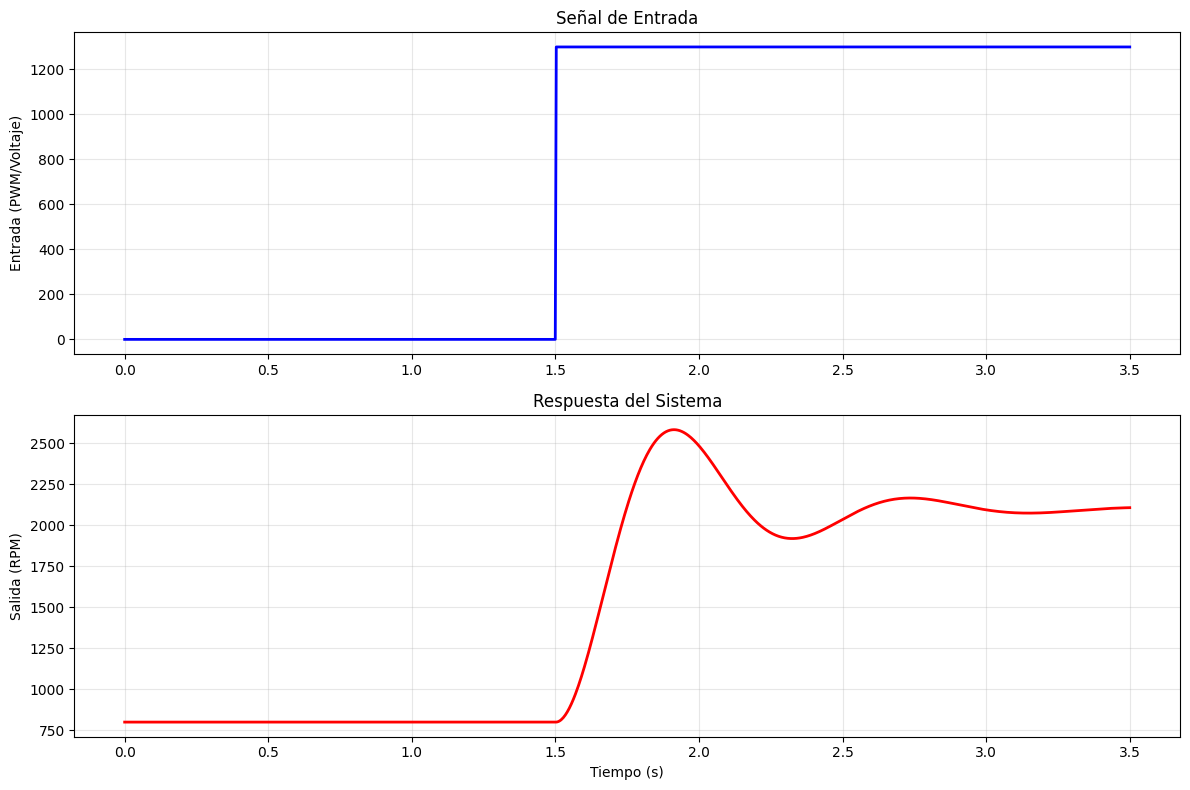

ANÁLISIS DE LA RESPUESTA SIMULADA
Valor inicial: 800.00 RPM
Valor final: 2101.40 RPM
Cambio total: 1301.40 RPM
Tiempo de subida (10%-90%): 0.165 s
Tiempo de establecimiento (2%): 1.671 s
Sobrepaso máximo: 37.1%
Tiempo de pico: 0.413 s


In [ ]:


class MotorSimulation:
    def __init__(self, K, wn, zeta):
        """
        Inicializa el simulador con los parámetros del modelo identificado
        
        Args:
            K: Ganancia estática
            wn: Frecuencia natural
            zeta: Factor de amortiguamiento
        """
        self.K = K
        self.wn = wn
        self.zeta = zeta
        
        # Crear función de transferencia
        num = [K * wn**2]
        den = [1, 2*zeta*wn, wn**2]
        self.H = ctrl.TransferFunction(num, den)
        
        # Datos de simulación
        self.time_sim = None
        self.rpm_sim = None
        self.input_signal = None
        
    def simulate_step_response(self, step_amplitude=1300, step_time=1.5, 
                              simulation_time=3.5, initial_value=800):
        """
        Simula la respuesta al escalón del sistema
        
        Args:
            step_amplitude: Amplitud del escalón
            step_time: Tiempo donde ocurre el escalón
            simulation_time: Tiempo total de simulación
            initial_value: Valor inicial del sistema
        """
        # Crear vector de tiempo
        self.time_sim = np.linspace(0, simulation_time, 1000)
        
        # Crear señal de entrada (escalón)
        self.input_signal = np.zeros_like(self.time_sim)
        step_idx = np.where(self.time_sim >= step_time)[0][0]
        self.input_signal[step_idx:] = step_amplitude
        
        # Simular la respuesta
        time_rel = self.time_sim - self.time_sim[0]
        
        # Usar forced_response para simulación con entrada arbitraria
        _, self.rpm_sim = ctrl.forced_response(self.H, time_rel, self.input_signal)
        
        # Agregar valor inicial
        self.rpm_sim = self.rpm_sim + initial_value
        
        return self.time_sim, self.rpm_sim
    
    def simulate_custom_input(self, time_vector, input_signal, initial_value=0):
        """
        Simula el sistema con una entrada personalizada
        
        Args:
            time_vector: Vector de tiempo
            input_signal: Señal de entrada personalizada
            initial_value: Valor inicial del sistema
        """
        self.time_sim = np.array(time_vector)
        self.input_signal = np.array(input_signal)
        
        # Simular la respuesta
        time_rel = self.time_sim - self.time_sim[0]
        
        _, self.rpm_sim = ctrl.forced_response(self.H, time_rel, self.input_signal)
        
        # Agregar valor inicial
        self.rpm_sim = self.rpm_sim + initial_value
        
        return self.time_sim, self.rpm_sim
    
    def plot_simulation(self, show_input=True):
        """
        Grafica los resultados de la simulación
        
        Args:
            show_input: Si mostrar la señal de entrada
        """
        if self.time_sim is None or self.rpm_sim is None:
            print("Error: Primero debe ejecutar una simulación")
            return
        
        if show_input:
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
            
            # Gráfica de la señal de entrada
            ax1.plot(self.time_sim, self.input_signal, 'b-', linewidth=2)
            ax1.set_ylabel('Entrada (PWM/Voltaje)')
            ax1.set_title('Señal de Entrada')
            ax1.grid(True, alpha=0.3)
            
            # Gráfica de la respuesta
            ax2.plot(self.time_sim, self.rpm_sim, 'r-', linewidth=2)
            ax2.set_xlabel('Tiempo (s)')
            ax2.set_ylabel('Salida (RPM)')
            ax2.set_title('Respuesta del Sistema')
            ax2.grid(True, alpha=0.3)
            
        else:
            fig, ax = plt.subplots(figsize=(10, 6))
            ax.plot(self.time_sim, self.rpm_sim, 'r-', linewidth=2)
            ax.set_xlabel('Tiempo (s)')
            ax.set_ylabel('RPM')
            ax.set_title('Respuesta del Sistema en Lazo Abierto')
            ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def analyze_response(self):
        """
        Analiza las características de la respuesta simulada
        """
        if self.time_sim is None or self.rpm_sim is None:
            print("Error: Primero debe ejecutar una simulación")
            return
        
        # Encontrar el escalón
        input_diff = np.diff(self.input_signal)
        step_idx = np.where(np.abs(input_diff) > 0.1 * np.max(np.abs(input_diff)))[0]
        
        if len(step_idx) == 0:
            print("No se detectó escalón en la entrada")
            return
        
        step_idx = step_idx[0]
        
        # Extraer respuesta después del escalón
        response = self.rpm_sim[step_idx:]
        time_step = self.time_sim[step_idx:] - self.time_sim[step_idx]
        
        # Calcular métricas
        initial_value = self.rpm_sim[step_idx]
        final_value = np.mean(response[-50:])
        
        # Tiempo de subida (10% a 90%)
        val_10 = initial_value + 0.1 * (final_value - initial_value)
        val_90 = initial_value + 0.9 * (final_value - initial_value)
        
        idx_10 = np.where(response >= val_10)[0]
        idx_90 = np.where(response >= val_90)[0]
        
        if len(idx_10) > 0 and len(idx_90) > 0:
            rise_time = time_step[idx_90[0]] - time_step[idx_10[0]]
        else:
            rise_time = None
        
        # Tiempo de establecimiento (2% del valor final)
        tolerance = 0.02 * abs(final_value - initial_value)
        settling_idx = None
        
        for i in range(len(response)-1, -1, -1):
            if abs(response[i] - final_value) > tolerance:
                settling_idx = i + 1
                break
        
        settling_time = time_step[settling_idx] if settling_idx else time_step[-1]
        
        # Sobrepaso máximo
        max_value = np.max(response)
        if max_value > final_value:
            overshoot = (max_value - final_value) / (final_value - initial_value) * 100
            peak_time = time_step[np.argmax(response)]
        else:
            overshoot = 0
            peak_time = None
        
        # Mostrar resultados
        print("="*50)
        print("ANÁLISIS DE LA RESPUESTA SIMULADA")
        print("="*50)
        print(f"Valor inicial: {initial_value:.2f} RPM")
        print(f"Valor final: {final_value:.2f} RPM")
        print(f"Cambio total: {final_value - initial_value:.2f} RPM")
        
        if rise_time:
            print(f"Tiempo de subida (10%-90%): {rise_time:.3f} s")
        
        print(f"Tiempo de establecimiento (2%): {settling_time:.3f} s")
        print(f"Sobrepaso máximo: {overshoot:.1f}%")
        
        if peak_time:
            print(f"Tiempo de pico: {peak_time:.3f} s")
        
        print("="*50)
        
        return {
            'initial_value': initial_value,
            'final_value': final_value,
            'rise_time': rise_time,
            'settling_time': settling_time,
            'overshoot': overshoot,
            'peak_time': peak_time
        }
    

# Ejemplo de uso
if __name__ == "__main__":
    # Parámetros del modelo identificado (ejemplo)
    K = 1.0
    wn = 8.0
    zeta = 0.3
    
    # Crear simulador
    simulator = MotorSimulation(K, wn, zeta)
    
    print("Simulando respuesta al escalón...")
    
    # Simular respuesta al escalón
    time_sim, rpm_sim = simulator.simulate_step_response(
        step_amplitude=1300, 
        step_time=1.5, 
        simulation_time=3.5,
        initial_value=800
    )
    
    # Mostrar gráfica
    simulator.plot_simulation(show_input=True)
    
    # Analizar respuesta
    metrics = simulator.analyze_response()

### **Simulación con controlador por espacio de estados:**





In [ ]:
import numpy as np
import control as ctrl

# Parámetros identificados
K = 2084.9898
wn = 35.3737
zeta = 0.7204

# Matrices del sistema para velocidad
A_vel = np.array([[0, 1],
                 [-wn**2, -2*zeta*wn]])
B_vel = np.array([[0],
                 [K * wn**2]])
C_vel = np.array([[1, 0]])  # Salida = velocidad
D_vel = np.array([[0]])

# Crear el sistema
sys_vel = ctrl.ss(A_vel, B_vel, C_vel, D_vel)

## DISEÑO DEL CONTROLADOR
# Polos deseados (según especificaciones: ts=0.4s, Mp<10%)
polo_deseado_vel = [-10 + 13.64j, -10 - 13.64j]

# Cálculo de la ganancia K por colocación de polos
K_vel = ctrl.place(A_vel, B_vel, polo_deseado_vel)
print("Ganancia de realimentación para velocidad:")
print(K_vel)

# Precompensación N_bar para seguimiento de referencia
N_bar_vel = -1.0 / (C_vel @ np.linalg.inv(A_vel - B_vel @ K_vel) @ B_vel)
B_vel_scaled = B_vel * N_bar_vel

# Sistema en lazo cerrado
A_cl_vel = A_vel - B_vel @ K_vel
sys_cl_vel = ctrl.ss(A_cl_vel, B_vel_scaled, C_vel, D_vel)

# Simulación
t_vel = np.linspace(0, 2, 500)
t_out_vel, y_out_vel = ctrl.step_response(sys_cl_vel, T=t_vel)

# Gráfico
import matplotlib.pyplot as plt
plt.plot(t_out_vel, y_out_vel)
plt.title("Respuesta al escalón - Control de Velocidad")
plt.xlabel("Tiempo (s)")
plt.ylabel("Velocidad (RPM)")
plt.grid(True)
plt.show()



#### **Implementación para Control de Posición**

In [ ]:
# Matrices del sistema extendido (orden 3 para posición)
A_pos = np.array([[0, 1, 0],
                 [0, 0, 1],
                 [0, -wn**2, -2*zeta*wn]])
B_pos = np.array([[0],
                 [0],
                 [K * wn**2]])
C_pos = np.array([[1, 0, 0]])  # Salida = posición
D_pos = np.array([[0]])

# Crear el sistema
sys_pos = ctrl.ss(A_pos, B_pos, C_pos, D_pos)

# Polos deseados para posición (más lentos y amortiguados)
polo1_pos = -4 + 5j
polo2_pos = -4 - 5j
polo3_pos = -8  # Polo real adicional
polo_deseado_pos = [polo1_pos, polo2_pos, polo3_pos]

# Cálculo de la ganancia K por colocación de polos
K_pos = ctrl.place(A_pos, B_pos, polo_deseado_pos)
print("Ganancia de realimentación para posición:")
print(K_pos)

# Precompensación N_bar para seguimiento de referencia
N_bar_pos = -1.0 / (C_pos @ np.linalg.inv(A_pos - B_pos @ K_pos) @ B_pos)
B_pos_scaled = B_pos * N_bar_pos
print("Precompensación N_bar para posición:", N_bar_pos)

# Sistema en lazo cerrado
A_cl_pos = A_pos - B_pos @ K_pos
sys_cl_pos = ctrl.ss(A_cl_pos, B_pos_scaled, C_pos, D_pos)

# Simulación
t_pos = np.linspace(0, 5, 500)
t_out_pos, y_out_pos = ctrl.step_response(sys_cl_pos, T=t_pos)

# Gráfico
plt.plot(t_out_pos, y_out_pos)
plt.title("Respuesta al escalón - Control de Posición")
plt.xlabel("Tiempo (s)")
plt.ylabel("Posición (RPM-s)")
plt.grid(True)
plt.show()

#### **Análisis de Robustez para control de velocidad**

In [ ]:
# Planta perturbada (mayor inercia y fricción)
wn_pert = wn * 0.7
zeta_pert = zeta * 1.2

A_vel_pert = np.array([[0, 1],
                      [-wn_pert**2, -2*zeta_pert*wn_pert]])
B_vel_pert = np.array([[0],
                      [K * wn_pert**2]])

# Recalcular N_bar para planta perturbada
N_bar_vel_pert = -1.0 / (C_vel @ np.linalg.inv(A_vel_pert - B_vel_pert @ K_vel) @ B_vel_pert)
B_vel_pert_scaled = B_vel_pert * N_bar_vel_pert

# Sistema perturbado en lazo cerrado
A_cl_vel_pert = A_vel_pert - B_vel_pert @ K_vel
sys_vel_pert = ctrl.ss(A_cl_vel_pert, B_vel_pert_scaled, C_vel, D_vel)

# Simulación comparativa
t_vel_pert, y_vel_pert = ctrl.step_response(sys_vel_pert, T=t_vel)

plt.plot(t_out_vel, y_out_vel, label='Planta nominal')
plt.plot(t_vel_pert, y_vel_pert, '--', label='Planta perturbada')
plt.title("Robustez - Control de Velocidad")
plt.xlabel("Tiempo (s)")
plt.ylabel("Velocidad (RPM)")
plt.grid(True)
plt.legend()
plt.show()

#### **Análisis de Robustez para control de posición**


In [ ]:
# Planta perturbada para posición
A_pos_pert = np.array([[0, 1, 0],
                      [0, 0, 1],
                      [0, -wn_pert**2, -2*zeta_pert*wn_pert]])
B_pos_pert = np.array([[0],
                      [0],
                      [K * wn_pert**2]])

# Recalcular N_bar para planta perturbada
N_bar_pos_pert = -1.0 / (C_pos @ np.linalg.inv(A_pos_pert - B_pos_pert @ K_pos) @ B_pos_pert)
B_pos_pert_scaled = B_pos_pert * N_bar_pos_pert

# Sistema perturbado en lazo cerrado
A_cl_pos_pert = A_pos_pert - B_pos_pert @ K_pos
sys_pos_pert = ctrl.ss(A_cl_pos_pert, B_pos_pert_scaled, C_pos, D_pos)

# Simulación comparativa
t_pos_pert, y_pos_pert = ctrl.step_response(sys_pos_pert, T=t_pos)

plt.plot(t_out_pos, y_out_pos, label='Planta nominal')
plt.plot(t_pos_pert, y_pos_pert, '--', label='Planta perturbada')
plt.title("Robustez - Control de Posición")
plt.xlabel("Tiempo (s)")
plt.ylabel("Posición (RPM-s)")
plt.grid(True)
plt.legend()
plt.show()

## 6. Implementación en Hardware


In [ ]:
import serial
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from collections import deque

import time


# Configura tu puerto y velocidad
PORT = 'COM6'     # Cámbialo a '/dev/ttyUSB0' o similar en Linux
BAUDRATE = 115200
BUFFER_SIZE = 200

# Inicializar buffers
angulo_buffer = deque([0.0]*BUFFER_SIZE, maxlen=BUFFER_SIZE)
rpm_buffer = deque([0.0]*BUFFER_SIZE, maxlen=BUFFER_SIZE)

# Inicializar conexión serial
ser = serial.Serial(PORT, BAUDRATE, timeout=1)

# Variables para cálculo de RPM
ultimo_angulo = None
ultimo_tiempo = None

def corregir_delta_angulo(delta):
    if delta > 180:
        delta -= 360
    elif delta < -180:
        delta += 360
    return delta

def update(frame):
    global ultimo_angulo, ultimo_tiempo

    try:
        line = ser.readline().decode().strip()
        if line:
            angulo = float(line)
            angulo_buffer.append(angulo)

            t_actual = time.time()

            if ultimo_angulo is not None and ultimo_tiempo is not None:
                delta_angulo = corregir_delta_angulo(angulo - ultimo_angulo)
                delta_tiempo = t_actual - ultimo_tiempo

                if delta_tiempo > 0:
                    rpm = (delta_angulo / 360.0) / delta_tiempo * 60.0
                    rpm_buffer.append(rpm)
                else:
                    rpm_buffer.append(0.0)
            else:
                rpm_buffer.append(0.0)

            ultimo_angulo = angulo
            ultimo_tiempo = t_actual

    except Exception as e:
        print("Error:", e)

    # Graficar ángulo
    ax1.clear()
    ax1.plot(angulo_buffer)
    ax1.set_ylim(0, 360)
    ax1.set_title("Ángulo AS5600 (grados)")
    ax1.set_ylabel("Ángulo (°)")
    ax1.set_xlabel("Muestras")

    # Graficar RPM
    ax2.clear()
    ax2.plot(rpm_buffer, color='orange')
    ax2.set_ylim(0, max(100, max(rpm_buffer)))
    ax2.set_title("Velocidad angular (RPM)")
    ax2.set_ylabel("RPM")
    ax2.set_xlabel("Muestras")

# Crear figura y ejes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ani = animation.FuncAnimation(fig, update, interval=20)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

CSV_FILENAME = "datos_motor.csv"
df = pd.read_csv(CSV_FILENAME)

# Ordenar por tiempo por si acaso
df = df.sort_values('timestamp').reset_index(drop=True)

time=[]
rpm=[]
# Calculo RPM
a=0
# Verificar si los datos son ascendentes o descendentes

try:
    for i in range(len(df['angle'])):
        angulo_actual = int(df['angle'][i])
        angulo_siguiente = int(df['angle'][i+1])
        if(int(df['angle'][i]) == int(df['angle'][i+1])):
            print("No hay cambio de ángulo")
            time.append(df['timestamp'][i]-df['timestamp'][0]) # Si no hay cambio de ángulo, se toma el tiempo actual
            rpm.append(0)
            a+=1
        elif(df['angle'][i+1]> df['angle'][i]):# Si el ángulo disminuye, significa que ha dado una vuelta completa
            time.append(df['timestamp'][i]-df['timestamp'][0])
            rpm.append(60/(time[a]-time[a-1])) # Calculo de RPM
            if rpm[a] > 8000:
                rpm[a] = rpm[a-1] # Si la RPM es mayor a 8000, se toma el valor anterior
            a+=1

except:
    print(len(time))
# Graficar
plt.plot(time, rpm, label='RPM')
plt.xlabel('Tiempo (s)')
plt.ylabel('RPM')
plt.title('RPM del motor')
plt.grid(True)
plt.legend()
plt.show()
# Convertir a radianes por segundo
rpm_rad = [x * (2 * 3.14159 / 60) for x in rpm]
# Guardar los datos de RPM en un nuevo CSV
df_rpm = pd.DataFrame({
    'time': time,
    'rpm': rpm,
    'rpm_rad': rpm_rad
})
df_rpm.to_csv('datos_rpm.csv', index=False)

In [ ]:
from machine import Pin, PWM, I2C
from as5600 import AS5600
import time
import sys
import select

# PWM setup
pwmA = PWM(Pin(2))
pwmB = PWM(Pin(3))
pwmA.freq(1000)
pwmB.freq(1000)

# I2C para AS5600
i2c = I2C(0, scl=Pin(1), sda=Pin(0))
sensor = AS5600(i2c)

# PWM inicial
pwm_value = 0

# Ángulo inicial como referencia
angle_offset = sensor.read_angle_deg()
print(f"Ángulo de referencia: {angle_offset:.2f}°")

# Variables para RPM
prev_angle = sensor.read_angle_deg()
prev_time = time.ticks_us()
rpm = 0

# Contador para imprimir con menos frecuencia
print_counter = 0

def motor_pwm(percent):
    duty = int(abs(percent) * 65535 / 100)
    if percent > 0:
        pwmA.duty_u16(duty)
        pwmB.duty_u16(0)
    elif percent < 0:
        pwmA.duty_u16(0)
        pwmB.duty_u16(duty)
    else:
        pwmA.duty_u16(0)
        pwmB.duty_u16(0)

# Bucle principal
while True:
    # Leer comando PWM del terminal si hay entrada
    if sys.stdin in select.select([sys.stdin], [], [], 0)[0]:
        try:
            line = sys.stdin.readline().strip()
            pwm_value = int(line)
            motor_pwm(pwm_value)
        except:
            pass

    # Tiempo actual en microsegundos
    current_time = time.ticks_us()
    dt = time.ticks_diff(current_time, prev_time) / 1_000_000  # a segundos

    if dt >= 0.002:  # mínimo 2 ms
        angle = sensor.read_angle_deg()
        angle_rel = (angle - angle_offset) % 360

        delta_angle = (angle - prev_angle) % 360
        if delta_angle > 180:
            delta_angle -= 360  # corrección si giró en sentido contrario

        rpm = (delta_angle / 360) / dt * 60

        prev_angle = angle
        prev_time = current_time

        print_counter += 1
        if print_counter >= 20:  # imprime cada 20 actualizaciones (~40 ms)
            print(f"Ángulo: {angle_rel:.2f}°, RPM: {rpm:.2f}")
            print_counter = 0

    # Muy pequeño para evitar saturación de CPU
    time.sleep_us(300)

## 7. Resultados Experimentales

Con el objetivo de validar la implementación práctica de los controladores diseñados en espacio de estados, se llevaron a cabo pruebas experimentales sobre una plataforma real basada en un motor DC, un sensor de posición AS5600, un puente H (driver L298N) y una placa compatible con Arduino. Se implementaron dos estrategias de control: una orientada a la regulación de velocidad y otra para el seguimiento de posición angular.

### **Control de velocidad**

Para la regulación de velocidad, se diseñó un controlador por realimentación de estados con precompensación, basado en la estimación en tiempo real de la velocidad angular del eje del motor (en RPM), a partir de los datos del sensor AS5600. El control se implementó directamente en la tarjeta microcontroladora (mediante MicroPython) y se utilizó una interfaz en Python para enviar referencias y visualizar las respuestas dinámicas.

Esta interfaz permite ingresar nuevas referencias de velocidad mediante consola y visualizar simultáneamente tres variables:

    - Velocidad deseada (referencia)

    - Velocidad real estimada

    - Señal de control aplicada (PWM)

Este seguimiento permite evaluar directamente el desempeño del controlador en cuanto a error estacionario, tiempo de establecimiento y suavidad de la acción de control.

In [ ]:
import serial
import time
import re
import threading
import matplotlib.pyplot as plt
from collections import deque

# --- Configuración del puerto serial ---
puerto = 'COM7'  # Cambia según tu sistema
baudrate = 115200
ser = serial.Serial(puerto, baudrate, timeout=1)
time.sleep(2)

# --- Referencia inicial de velocidad (RPM) ---
velocidad_ref = 0.0
ser.write(f"{int(velocidad_ref)}\n".encode())

# --- Función para cambiar velocidad por consola ---
def leer_consola():
    global velocidad_ref
    while True:
        try:
            entrada = input("Nueva velocidad deseada (RPM): ")
            nuevo = float(entrada.strip())
            if 0 <= nuevo <= 2500:
                velocidad_ref = nuevo
                ser.write(f"{int(velocidad_ref)}\n".encode())
                print(f"[PC] Nueva referencia: {velocidad_ref:.1f} RPM")
            else:
                print("[PC] Valor fuera de rango.")
        except:
            print("[PC] Entrada inválida.")

# --- Lanzar hilo para entrada por consola ---
hilo_consola = threading.Thread(target=leer_consola, daemon=True)
hilo_consola.start()

# --- Configurar gráfica en tiempo real ---
plt.ion()
fig, ax = plt.subplots()
line_ref, = ax.plot([], [], 'r--', label='Velocidad deseada')
line_rpm, = ax.plot([], [], 'b-', label='Velocidad actual')
line_pwm, = ax.plot([], [], 'g-', label='PWM aplicado')
ax.set_title("Seguimiento de velocidad en tiempo real")
ax.set_xlabel("Tiempo (s)")
ax.set_ylabel("Valor")
ax.grid(True)
ax.legend(loc="upper right")

buffer_size = 300
tiempo = deque(maxlen=buffer_size)
rpm_real = deque(maxlen=buffer_size)
pwm_aplicado = deque(maxlen=buffer_size)
rpm_deseada = deque(maxlen=buffer_size)

t_inicial = time.time()

# --- Bucle principal ---
while True:
    try:
        ser.reset_input_buffer()
        linea = ser.readline().decode().strip()
        match = re.search(r"RPM:\s*([-+]?[0-9]*\.?[0-9]+)\s*,\s*PWM:\s*([-+]?[0-9]*\.?[0-9]+)", linea)
        if match:
            rpm = float(match.group(1))
            pwm = float(match.group(2))

            t_actual = time.time() - t_inicial
            tiempo.append(t_actual)
            rpm_real.append(rpm)
            pwm_aplicado.append(pwm)
            rpm_deseada.append(velocidad_ref)

            line_ref.set_data(tiempo, rpm_deseada)
            line_rpm.set_data(tiempo, rpm_real)
            line_pwm.set_data(tiempo, pwm_aplicado)
            ax.set_xlim(max(0, t_actual - 10), t_actual + 1)
            ax.set_ylim(0, 2200)
            fig.canvas.draw()
            fig.canvas.flush_events()

            print(f"[PC] Ref: {velocidad_ref:.1f} RPM, Actual: {rpm:.2f} RPM, PWM: {pwm:.2f}%")

        time.sleep(0.01)

    except KeyboardInterrupt:
        print("Interrumpido por el usuario.")
        break

Por su parte, el código implementado en el microcontrolador (implementacion_Velocidad_Micro.py) realiza la estimación de velocidad, la aplicación de la ley de control del tipo:
$$
u=-K \cdot x+N_{\text {bar }} \cdot r
$$


Donde:
- $x=[\omega]$ es la velocidad angular medida,
- $K$ es la ganancia de realimentación,
- $r$ es la referencia (RPM deseada),
- $N_{\text {bar }}$ es el factor de precompensación.

Se establecieron condiciones de seguridad para evitar el sobrecontrol, como:

Saturación de la señal $u$ entre ±100%.

Zona muerta de 27% PWM (mínimo efectivo del driver).

Desactivación del control si el error cae por debajo del 10% de la referencia.

Análisis del comportamiento:
La velocidad del motor converge adecuadamente hacia la referencia con un sobreimpulso moderado, y sin oscilaciones notables.

El controlador mostró robustez frente a pequeñas perturbaciones de carga (frenado manual).

La acción de control PWM se mantuvo en márgenes razonables, evitando saturaciones prolongadas.

### **Control de Posición**

Para la tarea de seguimiento de posición, se extendió el modelo para incluir no solo la posición angular, sino también la velocidad y aceleración angular estimadas. Esto permitió implementar una estrategia de control multivariable en espacio de estados, con la siguiente estructura:

$$
x=\left[\begin{array}{c}
\theta \\
\omega \\
\alpha
\end{array}\right], \quad u=-K \cdot x+N_{\mathrm{bar}} \cdot \theta_{\mathrm{ref}}
$$

Se ejecuta este control directamente en el microcontrolador, utilizando:

- La lectura del ángulo absoluto desde el sensor AS5600.

- Estimación de velocidad y aceleración a través de diferencias finitas.

- Actualización de la señal de control cada 5 ms (200 Hz).

In [ ]:
import serial
import time
import re
import threading
import matplotlib.pyplot as plt
from collections import deque

# --- Configuración del puerto serial ---
puerto = 'COM7'  # Cambia según tu sistema
baudrate = 115200
ser = serial.Serial(puerto, baudrate, timeout=1)
time.sleep(2)

# --- Referencia inicial (global) ---
angulo_ref = 180.0
ser.write(f"{int(angulo_ref)}\n".encode())

# --- Función para escuchar entrada del usuario ---
def leer_consola():
    global angulo_ref
    while True:
        try:
            entrada = input("Nuevo ángulo deseado (0–360): ")
            nuevo = float(entrada.strip())
            if 0 <= nuevo <= 360:
                angulo_ref = nuevo
                ser.write(f"{int(angulo_ref)}\n".encode())
                print(f"[PC] Se actualizó la referencia a {angulo_ref:.1f}°")
            else:
                print("[PC] Valor fuera de rango.")
        except:
            print("[PC] Entrada inválida.")

# --- Lanzar hilo para entrada de consola ---
hilo_consola = threading.Thread(target=leer_consola, daemon=True)
hilo_consola.start()

# --- Configuración de gráfica en tiempo real ---
plt.ion()
fig, ax = plt.subplots()
line_ref, = ax.plot([], [], 'r--', label='Ángulo deseado')
line_ang, = ax.plot([], [], 'b-', label='Ángulo actual')
line_pwm, = ax.plot([], [], 'g-', label='PWM aplicado')
ax.set_title("Seguimiento del ángulo y PWM en tiempo real")
ax.set_xlabel("Tiempo (s)")
ax.set_ylabel("Valor")
ax.grid(True)
ax.legend(loc="upper right")

buffer_size = 300
tiempo = deque(maxlen=buffer_size)
angulo_real = deque(maxlen=buffer_size)
pwm_aplicado = deque(maxlen=buffer_size)
angulo_deseado = deque(maxlen=buffer_size)

t_inicial = time.time()

# --- Bucle principal de graficación ---
while True:
    try: 
        ser.reset_input_buffer()
        linea = ser.readline().decode().strip()
        match = re.search(r"Ángulo:\s*([-+]?[0-9]*\.?[0-9]+)°\s*,\s*RPM:\s*([-+]?[0-9]*\.?[0-9]+)\s*,\s*PWM:\s*([-+]?[0-9]*\.?[0-9]+)", linea)
        if match:
            angulo = float(match.group(1))
            pwm = float(match.group(3))

            t_actual = time.time() - t_inicial
            tiempo.append(t_actual)
            angulo_real.append(angulo)
            pwm_aplicado.append(pwm)
            angulo_deseado.append(angulo_ref)

            line_ref.set_data(tiempo, angulo_deseado)
            line_ang.set_data(tiempo, angulo_real)
            line_pwm.set_data(tiempo, pwm_aplicado)
            ax.set_xlim(max(0, t_actual - 10), t_actual + 1)
            ax.set_ylim(-50, 360)
            fig.canvas.draw()
            fig.canvas.flush_events()

            print(f"[PC] Ref: {angulo_ref:.1f}°, Ang: {angulo:.2f}°, PWM: {pwm:.2f}%")

        time.sleep(0.001)

    except KeyboardInterrupt:
        print("Interrumpido por el usuario.")
        break